# Triple Barrier Labeling Strategy

## Import the required libraries

In [32]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import yfinance as yf 

Create a function that gets the data from a certain stock

In [33]:
def get_data(symbol, begin_date=None, end_date=None):
    df = yf.download (symbol, start = begin_date, auto_adjust=True, end = end_date)
    df.columns = ['open', 'high', 'low', 'close', 'volume']

    return df

Getting the 10 year Apple Stock data from beginning of the year 2000 to the end of 2010, for example

In [34]:
symbol = 'AAPL'
start_date = '2000-01-01'
end_date = '2010-12-31'

apple_stock = get_data (symbol, start_date, end_date)
close_price = apple_stock['close']

[*********************100%***********************]  1 of 1 completed


# Calculating the Daily Volatility

# Option 1

Exponentially Weighted Moving Average (EWMA): Statistical Measure used to describe Time Series. It is a moving average that gives more weight to recent data points, making it more responsive to recent trends than a simple moving average (widely used in finance)

In [35]:
def get_daily_volatility (close, selected_span = 20):
    # Simple percentage returns
    df = close.pct_change()
    # 20 days EWMA (average number of trading days in a month)
    df = df.ewm(span = selected_span).std()
    df.dropna(inplace=True)
    return df

df_daily_volatility = get_daily_volatility(close_price)
df_daily_volatility


Date
2000-01-05    0.052151
2000-01-06    0.039935
2000-01-07    0.059064
2000-01-10    0.062937
2000-01-11    0.060214
                ...   
2010-12-23    0.007707
2010-12-27    0.007753
2010-12-28    0.007807
2010-12-29    0.007431
2010-12-30    0.007168
Name: close, Length: 2764, dtype: float64

# Option 2

Average True Range (ATR): Market Volatility Indicator. Typically, derivated from the 14-day simple moving average of a time series

In [36]:
def get_average_true_range (stock, window = 14):
    average_true_range_df = pd.Series(index=stock.index)
    high = pd.Series(stock.high.rolling(window, min_periods=window))
    low = pd.Series(stock.low.rolling(window, min_periods=window))
    close = pd.Series(stock.close.rolling(window, min_periods=window))

    for i in range(len(stock.index)):
        true_range = np.max([(high[i] - low[i]), np.abs(high[i] - close[i]), np.abs(low[i] - close[i])], axis = 0)
        average_true_range_df[i] = true_range.sum() / window
    
    return average_true_range_df

average_true_range_df = get_average_true_range(apple_stock)
average_true_range_df

C:\Users\al3xd\AppData\Local\Temp\ipykernel_744\2901594555.py:9: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  average_true_range_df[i] = true_range.sum() / window


Date
2000-01-03    0.005803
2000-01-04    0.010868
2000-01-05    0.014926
2000-01-06    0.021367
2000-01-07    0.024318
                ...   
2010-12-23    0.100059
2010-12-27    0.100080
2010-12-28    0.090914
2010-12-29    0.085418
2010-12-30    0.083229
Length: 2766, dtype: float64

# Setting the Boundaries 

Based on the measured volatility (option 1: EWMA)

In [ ]:
# How many days we hold the stock if neither barrier is hit. That is: Vertical Barrier
holding_period = 10
# Setting the multipliers for the top and bottom horizontal barriers
upper_and_lower_multipliers = [2, 2]
# Alligning the index
prices = close_price[df_daily_volatility.index]

def get_3_barriers():
    barriers = pd.DataFrame(columns=['days_passed', 'price', 'vertical_barrier', 'top_barrier', 'bottom_barrier'], index=df_daily_volatility.index)
    for day, volatility in df_daily_volatility.items():
        days_passed = len(df_daily_volatility.loc[df_daily_volatility.index[0]: day])

        # Set Vertical Barrier (Maximum Holding Period):
        if (days_passed + holding_period < len(df_daily_volatility.index) and holding_period != 0):
            vertical_barrier = df_daily_volatility.index[days_passed + holding_period]
        else:
            # Set it to NaN's
            vertical_barrier = np.nan

        # Set Top Barrier (Profit Take Barrier)
        if upper_and_lower_multipliers[0] > 0:
            top_barrier = prices.loc[day] + prices.loc[day] * upper_and_lower_multipliers[0] * volatility
        else:
            top_barrier = pd.Series(index = prices.index)

        # Set Bottom Barrier (Stop Loss Barrier)
        if upper_and_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[day] - prices.loc[day] * upper_and_lower_multipliers[1] * volatility
        else:
            bottom_barrier = pd.Series(index = prices.index)

        barriers.loc[day, ['days_passed', 'price', 'vertical_barrier', 'top_barrier', 'bottom_barrier']] = days_passed, prices.loc[day], vertical_barrier, top_barrier, bottom_barrier
    return barriers

barrier = get_3_barriers()
barrier

,days_passed,price,vertical_barrier,top_barrier,bottom_barrier
Date,,,,,
2000-01-05,1,0.77953,2000-01-21 00:00:00,0.860837,0.698224
2000-01-06,2,0.797375,2000-01-24 00:00:00,0.861061,0.73369
2000-01-07,3,0.725057,2000-01-25 00:00:00,0.810707,0.639407
2000-01-10,4,0.766382,2000-01-26 00:00:00,0.862849,0.669914
2000-01-11,5,0.720831,2000-01-27 00:00:00,0.807639,0.634023
...,...,...,...,...,...
2010-12-23,2760,9.767609,NaN,9.918166,9.617051
2010-12-27,2761,9.702994,NaN,9.853452,9.552536
2010-12-28,2762,9.794961,NaN,9.947908,9.642013


Add a column to label the data (if it has crossed any of the barriers or not)

In [38]:
barrier['label'] = None
barrier.head()

,days_passed,price,vertical_barrier,top_barrier,bottom_barrier,label
Date,,,,,,
2000-01-05,1,0.77953,2000-01-21 00:00:00,0.860837,0.698224,None
2000-01-06,2,0.797375,2000-01-24 00:00:00,0.861061,0.73369,None
2000-01-07,3,0.725057,2000-01-25 00:00:00,0.810707,0.639407,None
2000-01-10,4,0.766382,2000-01-26 00:00:00,0.862849,0.669914,None
2000-01-11,5,0.720831,2000-01-27 00:00:00,0.807639,0.634023,None


# Labelling

Crossed the Top Barrier -> 1

Crossed the Bottom Barrier -> -1

Crossed the Vertical Barrier -> 0


In [39]:
def get_labels(data):
    for i in range(len(data.index)):
        # Define the first and last days of the window
        start = data.index[i]
        end = data.vertical_barrier[i]

        if pd.notna(end):
            # Assign the initial and final prices
            price_initial = data.price[start]
            price_final = data.price[end]

            # Assign the top and bottom barriers 
            top_barrier = data.top_barrier[i]
            bottom_barrier = data.bottom_barrier[i]

            # Update the label
            if (data.price[start:end] >= top_barrier).any():
                data['label'][i] = 1
            elif (data.price[start:end] <= bottom_barrier).any():
                data['label'][i] = -1
            else:
                data['label'][i] = 0
    return data


Update the 'label' column

In [ ]:
barriers = get_labels(data=barrier)

In [40]:
barriers

,days_passed,price,vertical_barrier,top_barrier,bottom_barrier,label
Date,,,,,,
2000-01-05,1,0.77953,2000-01-21 00:00:00,0.860837,0.698224,1
2000-01-06,2,0.797375,2000-01-24 00:00:00,0.861061,0.73369,1
2000-01-07,3,0.725057,2000-01-25 00:00:00,0.810707,0.639407,1
2000-01-10,4,0.766382,2000-01-26 00:00:00,0.862849,0.669914,1
2000-01-11,5,0.720831,2000-01-27 00:00:00,0.807639,0.634023,1
...,...,...,...,...,...,...
2010-12-23,2760,9.767609,NaN,9.918166,9.617051,None
2010-12-27,2761,9.702994,NaN,9.853452,9.552536,None
2010-12-28,2762,9.794961,NaN,9.947908,9.642013,None


Count the number of times each label is verified

In [41]:
barriers.label.value_counts()

label
1     1410
-1     806
0      537
Name: count, dtype: int64

# Plotting the prices's graph

### Example 1: Data in column 120

C:\Users\al3xd\AppData\Local\Temp\ipykernel_744\2672697867.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end = barriers.vertical_barrier[column]
C:\Users\al3xd\AppData\Local\Temp\ipykernel_744\2672697867.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  upper_barrier = barriers.top_barrier[column]
C:\Users\al3xd\AppData\Local\Temp\ipykernel_744\2672697867.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_barrier =

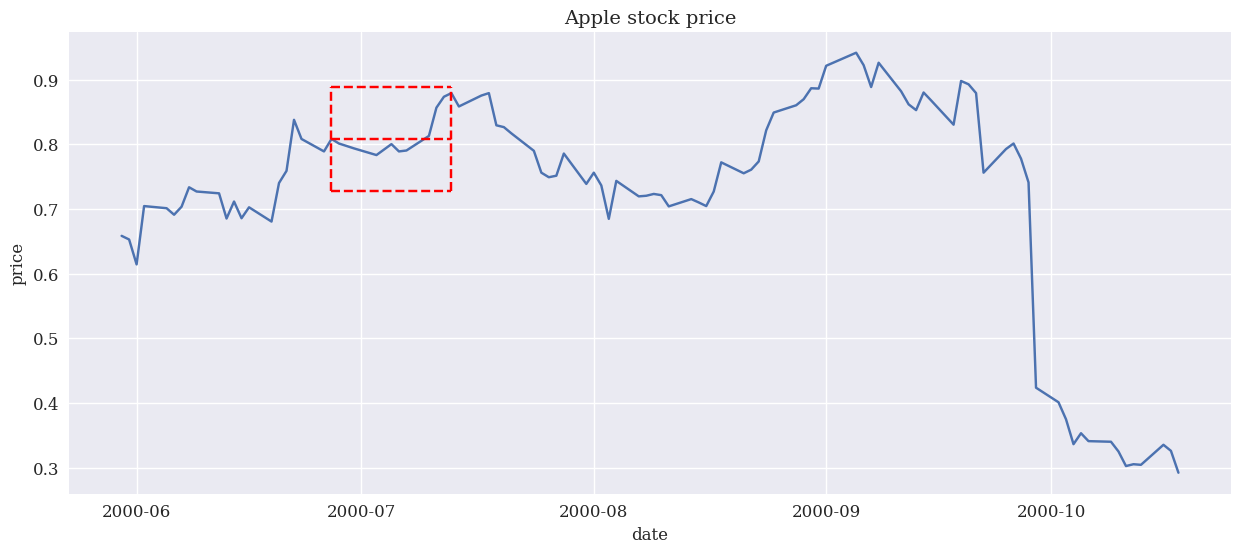

In [42]:
plt.style.use('seaborn-v0_8')
column = 120

plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'serif'

fig, ax = plt.subplots()
ax.set(title='Apple stock price',
       xlabel='date', ylabel='price')
ax.plot(barriers.price[100:200])
start = barriers.index[column]
end = barriers.vertical_barrier[column]
upper_barrier = barriers.top_barrier[column]
lower_barrier = barriers.bottom_barrier[column]
ax.plot([start, end], [upper_barrier, upper_barrier], 'r--')
ax.plot([start, end], [lower_barrier, lower_barrier], 'r--')
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5,
                       (lower_barrier + upper_barrier)*0.5], 'r--')
ax.plot([start, start], [lower_barrier, upper_barrier], 'r--')
ax.plot([end, end], [lower_barrier, upper_barrier], 'r--')


Interpretation:

Price moves sideways, oscillating between roughly 0.78–0.87.

It never reaches the top barrier (profit target) and never drops to the lower barrier (stop loss).

Time runs out when the price is still between the barriers → the vertical barrier is hit first (label is 0)

### Example 2: Data in column 152

C:\Users\al3xd\AppData\Local\Temp\ipykernel_744\2434076158.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end = barriers.vertical_barrier[column]
C:\Users\al3xd\AppData\Local\Temp\ipykernel_744\2434076158.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  upper_barrier = barriers.top_barrier[column]
C:\Users\al3xd\AppData\Local\Temp\ipykernel_744\2434076158.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_barrier = b

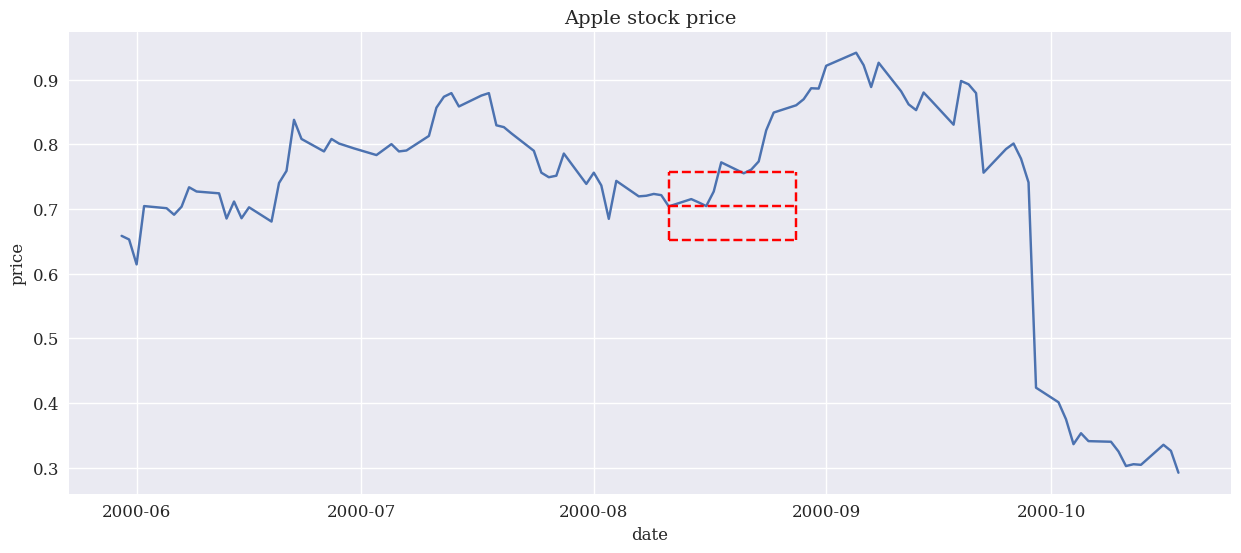

In [43]:
column = 152

fig, ax = plt.subplots()
ax.set(title='Apple stock price',
       xlabel='date', ylabel='price')
ax.plot(barriers.price[100:200])
start = barriers.index[column]
end = barriers.vertical_barrier[column]
upper_barrier = barriers.top_barrier[column]
lower_barrier = barriers.bottom_barrier[column]
ax.plot([start, end], [upper_barrier, upper_barrier], 'r--')
ax.plot([start, end], [lower_barrier, lower_barrier], 'r--')
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5,
                       (lower_barrier + upper_barrier)*0.5], 'r--')
ax.plot([start, start], [lower_barrier, upper_barrier], 'r--')
ax.plot([end, end], [lower_barrier, upper_barrier], 'r--')

Interpretation:

Price oscilates between 0.70 and 0.78.

It slightly exceeds the upper barrier (take-profit) before the vertical time limit is reached (label is 1).

The lower barrier (stop-loss) is never hit.

Eventhough the top barrier is hit twice, we only consider the first occurrence

### Example 3: Data in column 175

C:\Users\al3xd\AppData\Local\Temp\ipykernel_744\2562727312.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end = barriers.vertical_barrier[column]
C:\Users\al3xd\AppData\Local\Temp\ipykernel_744\2562727312.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  upper_barrier = barriers.top_barrier[column]
C:\Users\al3xd\AppData\Local\Temp\ipykernel_744\2562727312.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_barrier = b

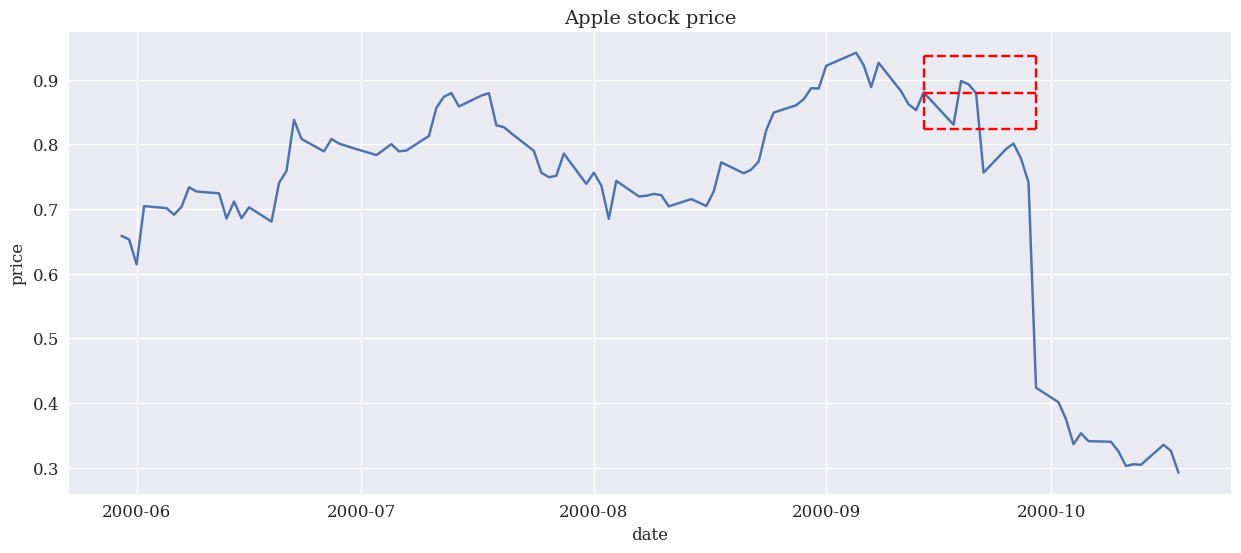

In [44]:
column = 175

fig, ax = plt.subplots()
ax.set(title='Apple stock price',
       xlabel='date', ylabel='price')
ax.plot(barriers.price[100:200])
start = barriers.index[column]
end = barriers.vertical_barrier[column]
upper_barrier = barriers.top_barrier[column]
lower_barrier = barriers.bottom_barrier[column]
ax.plot([start, end], [upper_barrier, upper_barrier], 'r--')
ax.plot([start, end], [lower_barrier, lower_barrier], 'r--')
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5,
                       (lower_barrier + upper_barrier)*0.5], 'r--')
ax.plot([start, start], [lower_barrier, upper_barrier], 'r--')
ax.plot([end, end], [lower_barrier, upper_barrier], 'r--')

Interpretation:

Price moves down shortly after the start and dips below the lower barrier before it ever reaches the upper barrier.

This means the stop-loss is triggered before the time limit or take-profit (label is -1).